## Main Question: ใครคือลูกค้าที่เราควรโฟกัส?

In [1]:
import numpy as np
import matplotlib 
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
from __future__ import division
from IPython.core.debugger import set_trace

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 500)

In [2]:
shoppings = pd.read_csv('./data/supermarket_data.csv')
shoppings['SHOP_DATE'] = shoppings['SHOP_DATE'].apply(str)
shoppings['SHOP_DATE'] = pd.to_datetime(shoppings['SHOP_DATE'], format='%Y%m%d')

In [46]:
shoppings['SHOP_DATE'].min()

Timestamp('2007-01-01 00:00:00')

In [3]:
shoppings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 671914 entries, 0 to 671913
Data columns (total 8 columns):
SHOP_DATE     671914 non-null datetime64[ns]
SHOP_HOUR     671914 non-null int64
BASKET_ID     671914 non-null int64
CUST_CODE     671914 non-null object
STORE_CODE    671914 non-null object
PROD_CODE     671914 non-null object
QUANTITY      671914 non-null int64
SPEND         671914 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(3), object(3)
memory usage: 41.0+ MB


จากคำถามที่ว่า "ใครคือลูกค้าที่เราควรโฟกัส?" ผมจึงเลือกใช้การทำ Customer Segmentation โดยใช้เทคนิคการวิเคราะห์ข้อมูล RFM Analysis
โดยวิธีการวิเคราะห์แบบ RMF จะแบ่งลูกค้าด้วยเกณฑ์ 3 เกณฑ์ คือ<br>
 1. Recency คือ จำนวนวันที่ลูกค้ามาซื้อครั้งล่าสุดนับจากปัจจุบัน<br>
 2. Frequency คือ จำนวนครั้งของการซื้อสินค้า<br>
 3. Monetary คือ ยอดรวมที่ลูกค้าเคยซื้อ
 

จากนั้นจะทำการคำนวนค่า Recency, Frequency และ Monetary  ของลูกค้าแต่ละคนได้ผลดังนี้

In [4]:
NOW = shoppings['SHOP_DATE'].max()
m_table = shoppings.groupby(['CUST_CODE','BASKET_ID'], as_index=False)['SPEND'].mean().drop(columns=['BASKET_ID']).groupby('CUST_CODE', as_index=False)['SPEND'].sum()
m_table = m_table.rename(columns={
    'SPEND' : 'monetary'
})

rf_table = shoppings.groupby(['CUST_CODE'], as_index=False).agg({
    'BASKET_ID': lambda x: len(x.unique()),
    'SHOP_DATE': lambda x: (NOW - x.max()).days
}).rename(columns={
    'BASKET_ID' : 'frequency',
    'SHOP_DATE' : 'recency'
})

ตัวอย่างคาราง RFM 

In [5]:
rmf_table = pd.merge(left=m_table, right=rf_table, on='CUST_CODE')
rmf_table.head()

,CUST_CODE,monetary,frequency,recency
0,CUST0000000107,0.800000,1,103
1,CUST0000000369,178.763940,126,1
2,CUST0000001388,3.814286,4,86
3,CUST0000002302,153.479111,71,3
4,CUST0000002637,8.821894,7,37


In [6]:
m_3nd_quantile = rmf_table['monetary'].quantile(.75)
r_3nd_quantile = rmf_table['recency'].quantile(.75)
f_3nd_quantile = rmf_table['frequency'].quantile(.75)

rmf_table['m_score'] = rmf_table['monetary'].apply(lambda x: 1 if x > m_3nd_quantile else 2)
rmf_table['r_score'] = rmf_table['recency'].apply(lambda x: 1 if x < r_3nd_quantile else 2)
rmf_table['f_score'] = rmf_table['frequency'].apply(lambda x: 1 if x > f_3nd_quantile else 2)
rmf_table['rmf'] = rmf_table['r_score'].apply(str) + rmf_table['m_score'].apply(str) + rmf_table['f_score'].apply(str)
rmf_table.head()

,CUST_CODE,monetary,frequency,recency,m_score,r_score,f_score,rmf
0,CUST0000000107,0.800000,1,103,2,1,2,122
1,CUST0000000369,178.763940,126,1,1,1,1,111
2,CUST0000001388,3.814286,4,86,2,1,2,122
3,CUST0000002302,153.479111,71,3,1,1,1,111
4,CUST0000002637,8.821894,7,37,2,1,2,122


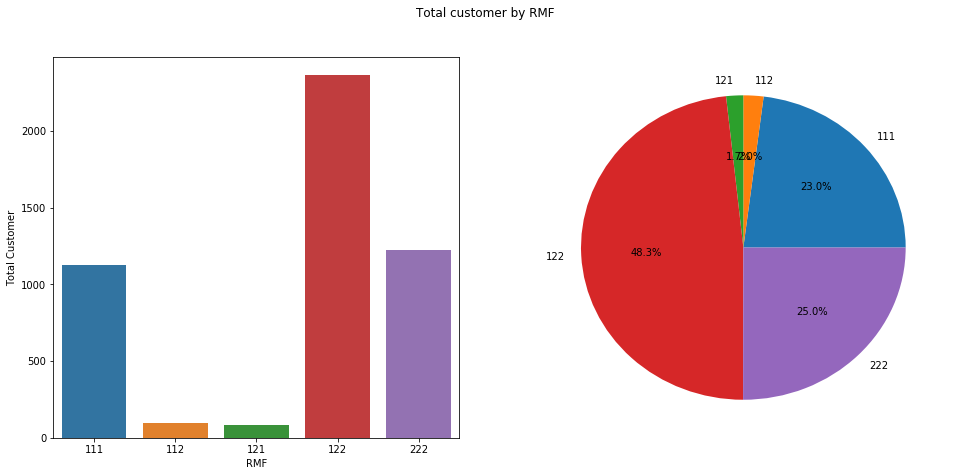

In [7]:
rmf_count = rmf_table.groupby('rmf', as_index=False)['CUST_CODE'].count()
plt.figure(figsize=(16, 7))
plt.gcf().suptitle('Total customer by RMF')
plt.subplot(121)
sns.barplot(data=rmf_count, x='rmf', y='CUST_CODE')
plt.ylabel('Total Customer')
plt.xlabel('RMF')
plt.subplot(122)
plt.pie(rmf_count['CUST_CODE'], labels=rmf_count['rmf'], autopct='%1.1f%%')
plt.show()

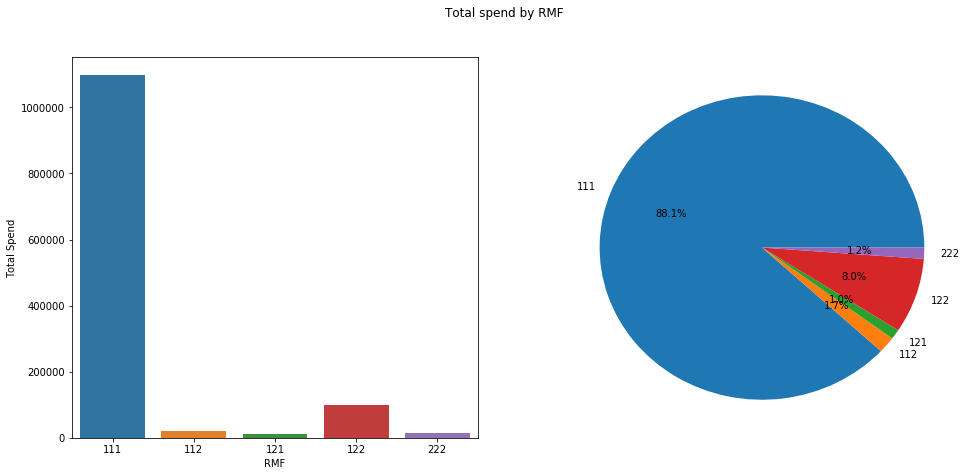

In [8]:
total_spend_by_customers = shoppings.groupby('CUST_CODE', as_index=False)['SPEND'].sum()
customers = pd.merge(total_spend_by_customers, rmf_table, on='CUST_CODE')
total_spend_by_rmf = customers.groupby('rmf', as_index=False)['SPEND'].sum()

plt.figure(figsize=(16, 7))
plt.gcf().suptitle('Total spend by RMF')
plt.subplot(121)
sns.barplot(data=total_spend_by_rmf, x='rmf', y='SPEND')
plt.ylabel('Total Spend')
plt.xlabel('RMF')
plt.subplot(122)
plt.pie(total_spend_by_rmf['SPEND'], labels=rmf_count['rmf'], autopct='%1.1f%%')
plt.show()

## First Tier Customers Analysis

In [9]:
first_tier_customer_code = rmf_table.loc[rmf_table['rmf'] == '111', 'CUST_CODE'].values

data = pd.merge(shoppings, rmf_table[['CUST_CODE', 'rmf']], on='CUST_CODE')
first_tier_customers = data.loc[data['rmf'] == '111']

### Which day they come?

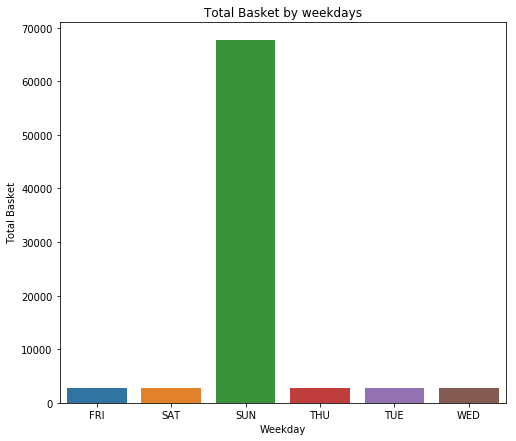

In [10]:
def map_to_weekday(x):
    if x == 0:
        return 'MON'
    elif x == 1:
        return 'TUE'
    elif x == 2:
        return 'WED'
    elif x == 3:
        return 'THU'
    elif x == 4:
        return 'FRI'
    elif x == 5:
        return 'SAT'
    else:
        return 'SUN'

first_tier_customers['weekday'] = first_tier_customers['SHOP_DATE'].apply(lambda x: map_to_weekday(x.day))

total_basket_by_weekday = first_tier_customers.groupby('weekday', as_index=False)['BASKET_ID'].agg(lambda x: len(x.unique()))

plt.figure(figsize=(8,7))
sns.barplot(data=total_basket_by_weekday, x='weekday', y='BASKET_ID')
#plt.pie(total_basket_by_weekday['BASKET_ID'], labels=total_basket_by_weekday['weekday'], autopct='%1.1f%%')
plt.title("Total Basket by weekdays")
plt.xlabel('Weekday')
plt.ylabel('Total Basket')
plt.show()

### Which time they come?

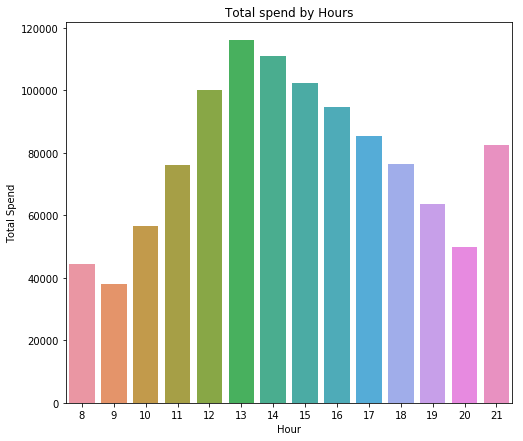

In [11]:
total_spend_by_shop_hour = first_tier_customers.groupby('SHOP_HOUR', as_index=False)['SPEND'].sum()

plt.figure(figsize=(8,7))
sns.barplot(data=total_spend_by_shop_hour, x='SHOP_HOUR', y='SPEND')
plt.title("Total spend by Hours")
plt.ylabel('Total Spend')
plt.xlabel('Hour')
plt.show()


### Which quater has the most sales?

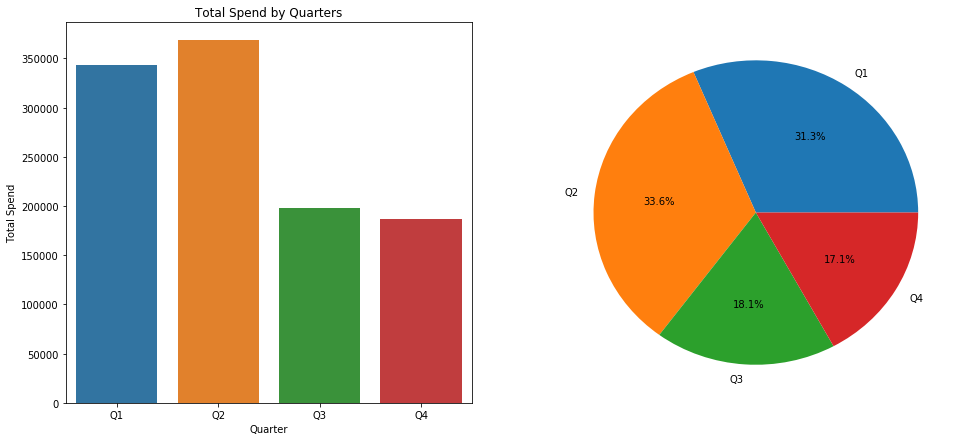

In [12]:
first_tier_customers['quarter'] = first_tier_customers['SHOP_DATE'].apply(lambda x: x.quarter)
total_spend_by_quarter = first_tier_customers.groupby('quarter', as_index=False)['SPEND'].sum()
total_spend_by_quarter['quarter'] = total_spend_by_quarter['quarter'].apply(lambda x: 'Q' + str(x))

plt.figure(figsize=(16,7))
plt.subplot(121)
sns.barplot(data=total_spend_by_quarter, x='quarter', y='SPEND')
plt.title("Total Spend by Quarters")
plt.ylabel('Total Spend')
plt.xlabel('Quarter')
plt.subplot(122)
plt.pie(total_spend_by_quarter['SPEND'], labels=total_spend_by_quarter['quarter'], autopct='%1.1f%%')
plt.show()

In [13]:
total = total_spend_by_quarter['SPEND'].sum()
def percentage(x, total):
    return (x / total) * 100
print(f"Q1: {percentage(total_spend_by_quarter.iloc[0]['SPEND'], total)}")
print(f"Q2: {percentage(total_spend_by_quarter.iloc[1]['SPEND'], total)}")
print(f"Q3: {percentage(total_spend_by_quarter.iloc[2]['SPEND'], total)}")
print(f"Q4: {percentage(total_spend_by_quarter.iloc[3]['SPEND'], total)}")

Q1: 31.277015364855128
Q2: 33.58640756203448
Q3: 18.083564367360417
Q4: 17.053012705749982


### Which store has the most sales?

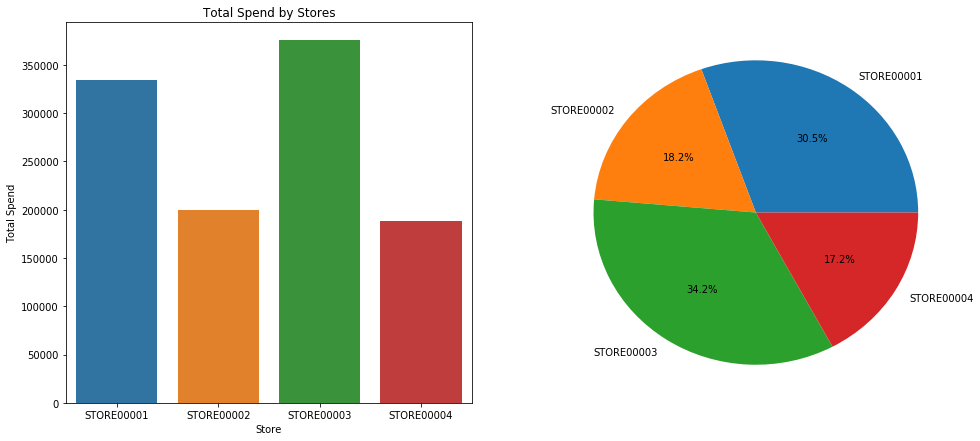

In [14]:
#total_basket_by_store = first_tier_customers.groupby('STORE_CODE', as_index=False)['BASKET_ID'].agg(lambda x: len(x.unique()))
total_spend_by_store = first_tier_customers.groupby('STORE_CODE', as_index=False)['SPEND'].sum()

plt.figure(figsize=(16,7))
plt.subplot(121)
sns.barplot(data=total_spend_by_store, x='STORE_CODE', y='SPEND')
plt.title("Total Spend by Stores")
plt.xlabel('Store')
plt.ylabel('Total Spend')
plt.subplot(122)
plt.pie(total_spend_by_store['SPEND'], labels=total_spend_by_store['STORE_CODE'], autopct='%1.1f%%')
plt.show()

### Which store has most of them?

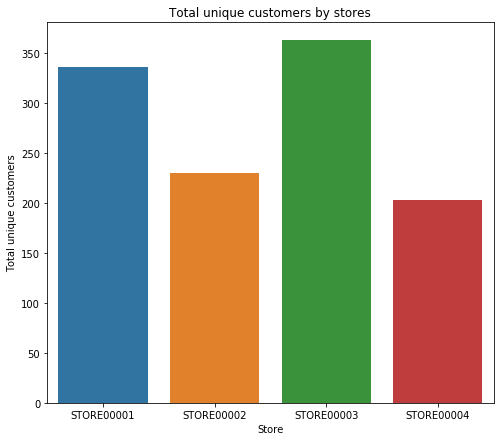

In [15]:
total_customers_by_store = first_tier_customers.groupby('STORE_CODE', as_index=False)['CUST_CODE'].agg(lambda x: len(x.unique()))

plt.figure(figsize=(8,7))
sns.barplot(data=total_customers_by_store, x='STORE_CODE', y='CUST_CODE')
plt.title("Total unique customers by stores")
plt.ylabel('Total unique customers')
plt.xlabel('Store')
plt.show()

### Which products they bought yeild most salse?

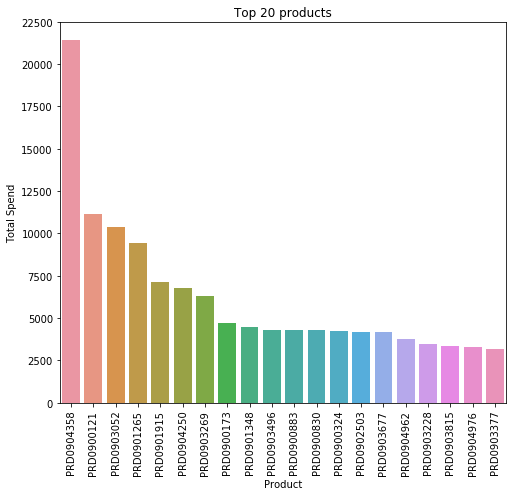

In [16]:
totle_spend_by_products = first_tier_customers.groupby('PROD_CODE', as_index=False)['SPEND'].sum()
top_products = totle_spend_by_products.sort_values('SPEND', ascending=False)[:20]

plt.figure(figsize=(8,7))
sns.barplot(data=top_products, x='PROD_CODE', y='SPEND')
plt.title("Top 20 products")
plt.xticks(rotation=90)
plt.ylabel('Total Spend')
plt.xlabel('Product')
plt.show()

In [17]:
total_spend = totle_spend_by_products['SPEND'].sum()
top_products_total_spend = top_products['SPEND'].sum()
best_product_spend = top_products.iloc[0]['SPEND']
print(f"PRD0904358 give the highest sales at {best_product_spend:.2f} or {(best_product_spend / total_spend) * 100:.2f} percentage of total spend spent by tier1 customers")
print(f"Top 20 products have sales at {top_products_total_spend:.2f} or {(top_products_total_spend / total_spend) * 100:.2f} percentage")
top_products_total_spend


PRD0904358 give the highest sales at 21401.38 or 1.95 percentage of total spend spent by tier1 customers
Top 20 products have sales at 124437.42 or 11.35 percentage


124437.42000000212

### Which product thay buy most?

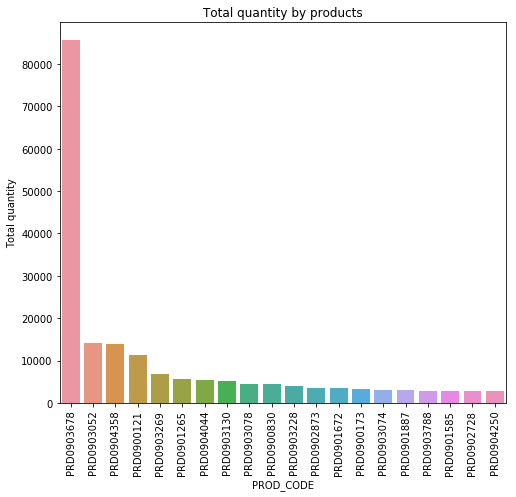

In [18]:
totle_shopped_by_products = first_tier_customers.groupby('PROD_CODE', as_index=False)['QUANTITY'].sum()
top_products = totle_shopped_by_products.sort_values('QUANTITY', ascending=False)[:20]

plt.figure(figsize=(8,7))
sns.barplot(data=top_products, x='PROD_CODE', y='QUANTITY')
plt.title("Total quantity by products")
plt.xticks(rotation=90)
plt.ylabel('Total quantity')
plt.show()

### How often they shopping?

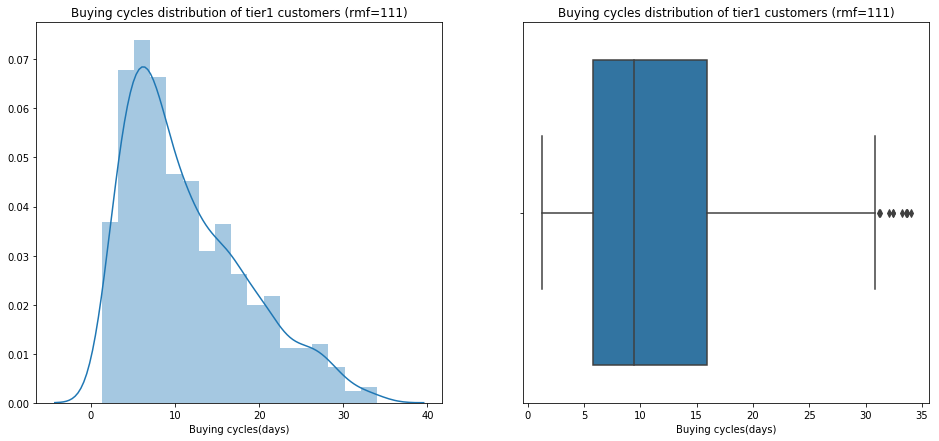

In [19]:
shoppings['SHOP_DATE_TIME'] = shoppings['SHOP_DATE'] + pd.to_timedelta(shoppings.SHOP_HOUR, unit='h')

grouped_customers = shoppings.groupby(['CUST_CODE','BASKET_ID'], as_index=False)

def dates_diff_mean(dates):
    if(len(dates) == 1):
        return np.nan
    else:
        dates = dates.sort_values()
        diff = (dates - dates.shift(periods=1))[1:].mean()
        #result = (diff.days * 24) + (diff.seconds / 3600)
        return diff

buy_cycle_by_customers = grouped_customers['SHOP_DATE_TIME'].agg(lambda x: x.iloc[0]).groupby('CUST_CODE', as_index=False)['SHOP_DATE_TIME'].agg(dates_diff_mean)
buy_cycle_by_customers['SHOP_DATE_TIME'] = buy_cycle_by_customers['SHOP_DATE_TIME'].apply(lambda x: np.nan if (x == np.nan) else (x.days * 24) + (x.seconds / 3600))
buy_cycle_by_customers.rename(columns={
    'SHOP_DATE_TIME' : 'buy_cycle_hours'
}, inplace=True)
buy_cycle_by_customers['buy_cycle_days'] = buy_cycle_by_customers['buy_cycle_hours'] / 24

buy_cycle_by_customers.drop(columns=['buy_cycle_hours'], inplace=True)

customers = pd.merge(customers, buy_cycle_by_customers, on='CUST_CODE')

mean_buy_cycle_by_tier1_customers = customers.loc[customers['rmf'] == '111', ['CUST_CODE','buy_cycle_days']]

plt.figure(figsize=(16,7))
plt.subplot(121)
sns.distplot(mean_buy_cycle_by_tier1_customers['buy_cycle_days'])
plt.title("Buying cycles distribution of tier1 customers (rmf=111)")
plt.xlabel('Buying cycles(days)')

plt.subplot(122)
sns.boxplot(mean_buy_cycle_by_tier1_customers['buy_cycle_days'])
plt.title("Buying cycles distribution of tier1 customers (rmf=111)")
plt.xlabel('Buying cycles(days)')
plt.show()


In [38]:
mean_buy_cycle_by_tier1_customers['buy_cycle_days'].quantile(.99)

30.38486203703703

In [33]:
mean_buy_cycle_by_tier1_customers['buy_cycle_days'].mean()

11.405498045267494

### Unit Price

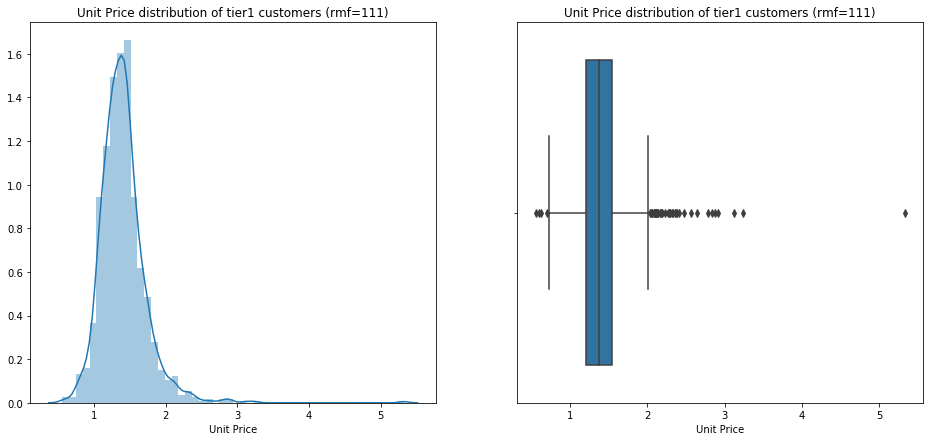

In [31]:
first_tier_customers['unit_price'] = first_tier_customers['SPEND'] / first_tier_customers['QUANTITY']
mean_unit_price_by_customers = first_tier_customers.groupby('CUST_CODE', as_index=False)['unit_price'].mean()

plt.figure(figsize=(16, 7))
plt.subplot(121)
sns.distplot(mean_unit_price_by_customers['unit_price'])
plt.title('Unit Price distribution of tier1 customers (rmf=111)')
plt.xlabel('Unit Price')

plt.subplot(122)
sns.boxplot(mean_unit_price_by_customers['unit_price'])
plt.title('Unit Price distribution of tier1 customers (rmf=111)')
plt.xlabel('Unit Price')
plt.show()

In [40]:
mean_unit_price_by_customers['unit_price'].quantile(.99)

2.3831488807263153

In [39]:
mean_unit_price_by_customers['unit_price'].mean()

1.4076914284309778

90% ของลูกค่าtier1 จะซื้อของราคาเฉลี่ยน้อยกว่าหรือเท่ากับ 1.75

### QUANTITY mean by customers

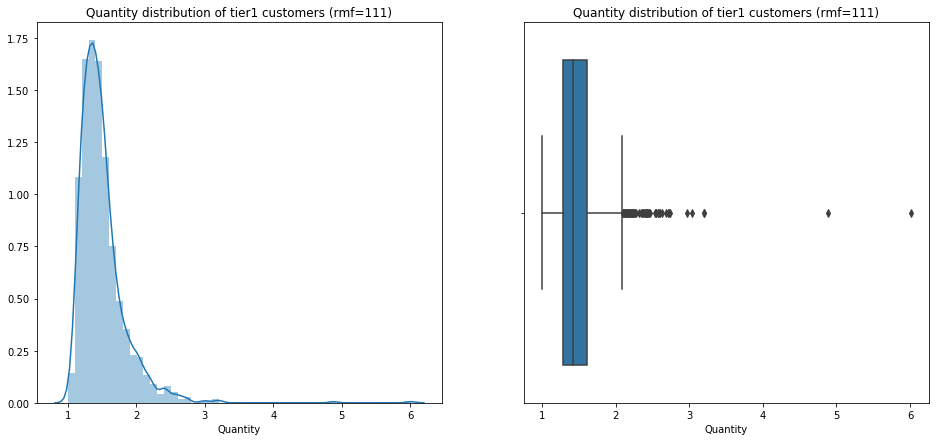

In [32]:
mean_quantity_by_customers = first_tier_customers.groupby('CUST_CODE', as_index=False)['QUANTITY'].mean()

plt.figure(figsize=(16, 7))
plt.subplot(121)
sns.distplot(mean_quantity_by_customers['QUANTITY'])
plt.title('Quantity distribution of tier1 customers (rmf=111)')
plt.xlabel('Quantity')

plt.subplot(122)
sns.boxplot(mean_quantity_by_customers['QUANTITY'])
plt.title('Quantity distribution of tier1 customers (rmf=111)')
plt.xlabel('Quantity')

plt.show()

In [24]:
mean_quantity_by_customers['QUANTITY'].quantile(.99)

1.8915210261945288

In [41]:
mean_quantity_by_customers['QUANTITY'].mean()

1.4969542238209659

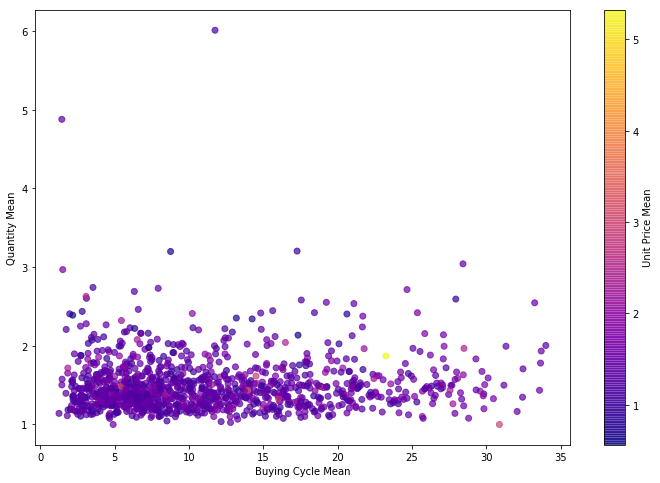

In [43]:
from functools import reduce
data = reduce(lambda left, right: pd.merge(left, right, on='CUST_CODE'), [mean_unit_price_by_customers, mean_buy_cycle_by_tier1_customers, mean_quantity_by_customers])
data.rename(columns={
    'unit_price' : 'mean_unit_price',
    'QUANTITY' : 'mean_quantity',
    'buy_cycle_days' : 'mean_buy_cycle_days'
}, inplace=True)
plt.figure(figsize=(12,8))
plt.scatter(data=data, x='mean_buy_cycle_days', y='mean_quantity', c='mean_unit_price', alpha=0.7, cmap='plasma')
plt.xlabel("Buying Cycle Mean")
plt.ylabel("Quantity Mean")
cbar = plt.colorbar()
cbar.ax.set_ylabel("Unit Price Mean")
plt.show()

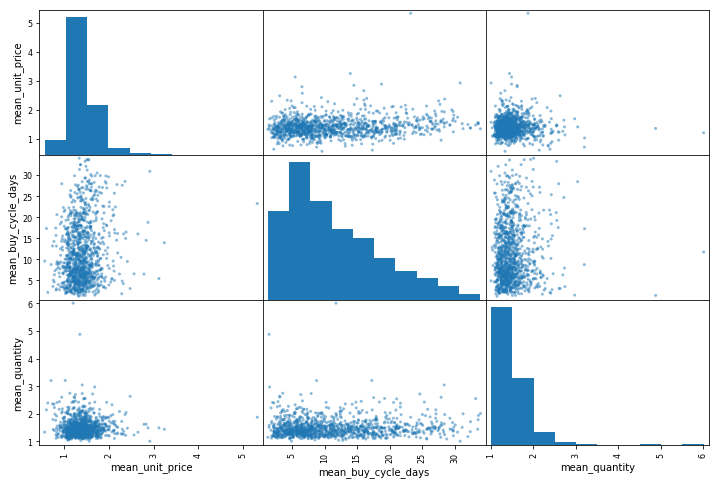

In [26]:
from pandas.tools.plotting import scatter_matrix
scatter_matrix(data, figsize=(12, 8))
plt.show()

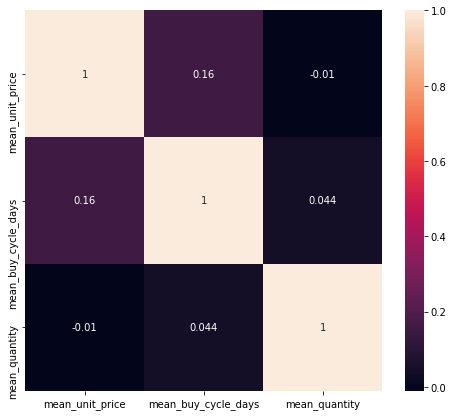

In [27]:
plt.figure(figsize=(8, 7))
sns.heatmap(data.corr(), annot=True)
plt.show()